# TASK 4: Color
Support colour sequences taking advantage of the chromatic components from different color spaces.

In [23]:
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as pltÇ
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../datasets/AICity_data/train/S03/c010/'
plt.style.use("default")

In [24]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')
gt_notParked = getNotParkedCars(gt_detect)

Try RGB, HS from HSV, UV from YUV, AB from LAB

In [25]:
# @ 30s UOC Server
color_spaces = {"RGB": cv2.COLOR_BGR2RGB,"HSV": cv2.COLOR_BGR2HSV, "LAB": cv2.COLOR_BGR2LAB, 'YUV': cv2.COLOR_BGR2YUV}
means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames

100%|██████████| 410/410 [00:09<00:00, 44.52it/s]


In [21]:
def remove_background_adaptative_color(means, stds, videoPath, ROIpath, alpha=4, sigma=2, p=0.1, color="RGB"):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            # Read Color Image
            img_color = cv2.cvtColor(image, color_spaces[color])
            # Split Channels
            img_color_C1 = img_color[:, :, 0]
            img_color_C2 = img_color[:, :, 1]
            img_color_C3 = img_color[:, :, 2]
            # Mask per Channel
            img_mask_C1 = np.zeros(img_color_C1.shape, dtype=np.uint8)
            img_mask_C2 = np.zeros(img_color_C2.shape, dtype=np.uint8)
            img_mask_C3 = np.zeros(img_color_C3.shape, dtype=np.uint8)
            # Compute mask with formula
            if color == "RGB":
                img_mask_C1[abs(img_color_C1 - means[0]) >= alpha * (stds[0] + sigma)] = 255
                img_mask_C2[abs(img_color_C2 - means[1]) >= alpha * (stds[1] + sigma)] = 255
                img_mask_C3[abs(img_color_C3 - means[2]) >= alpha * (stds[2] + sigma)] = 255
                # USING RGB
                img_mask = img_mask_C1 + img_mask_C2 + img_mask_C3

                img_mask[img_mask > 0] = 255
            
            if color == "HSV":
                img_mask_C1[abs(img_color_C1 - means[0]) >= alpha * (stds[0] + sigma)] = 255
                img_mask_C2[abs(img_color_C2 - means[1]) >= alpha * (stds[1] + sigma)] = 255
                img_mask_C3[abs(img_color_C3 - means[2]) >= alpha * (stds[2] + sigma)] = 255
                # USING HS
                img_mask = img_mask_C1 + img_mask_C2

                img_mask[img_mask > 0] = 255
            
            if color == "YUV":
                img_mask_C1[abs(img_color_C1 - means[0]) >= alpha * (stds[0] + sigma)] = 255
                img_mask_C2[abs(img_color_C2 - means[1]) >= alpha * (stds[1] + sigma)] = 255
                img_mask_C3[abs(img_color_C3 - means[2]) >= alpha * (stds[2] + sigma)] = 255
                img_mask = img_mask_C2 + img_mask_C3
                # USING UV
                img_mask[img_mask > 0] = 255
            
            if color == "LAB":
                img_mask_C1[abs(img_color_C1 - means[0]) >= alpha * (stds[0] + sigma)] = 255
                img_mask_C2[abs(img_color_C2 - means[1]) >= alpha * (stds[1] + sigma)] = 255
                img_mask_C3[abs(img_color_C3 - means[2]) >= alpha * (stds[2] + sigma)] = 255
                img_mask = img_mask_C2 + img_mask_C3
                # USING AB
                img_mask[img_mask > 0] = 255

            cleaned = cleanMask(img_mask, roi)
            cv2.imwrite(f'./masks_adaptative_{color}/mask_{frame}.png', cleaned)

            #update mean
            idxs = cleaned == 0
            means[0][idxs] = p * img_color_C1[idxs] + (1 - p) * means[0][idxs]
            means[1][idxs] = p * img_color_C2[idxs] + (1 - p) * means[1][idxs]
            means[2][idxs] = p * img_color_C3[idxs] + (1 - p) * means[2][idxs]
            #update std
            stds[0][idxs] = np.sqrt(p * (img_color_C1[idxs] - means[0][idxs])**2 + (1 - p) * stds[0][idxs]**2)
            stds[1][idxs] = np.sqrt(p * (img_color_C2[idxs] - means[1][idxs])**2 + (1 - p) * stds[1][idxs]**2)
            stds[2][idxs] = np.sqrt(p * (img_color_C3[idxs] - means[2][idxs])**2 + (1 - p) * stds[2][idxs]**2)

            detections[str(frame)] = getBoxesFromMask(cleaned)

    return detections

100%|██████████| 2141/2141 [05:37<00:00,  6.35it/s]


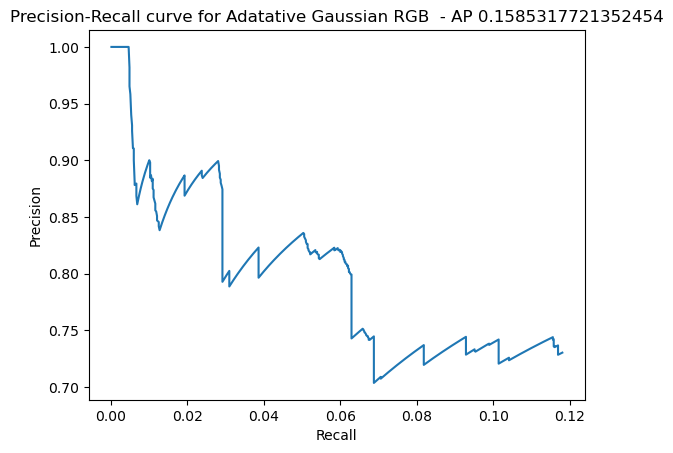

In [5]:
# @5min
singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',4,2,0.07, "RGB")
recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian RGB  - AP {np.mean(aps)}')

100%|██████████| 2141/2141 [05:09<00:00,  6.92it/s]


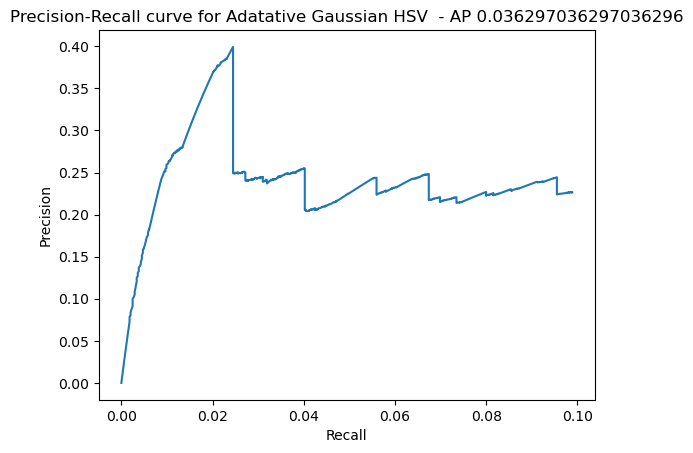

In [6]:
# @5min
means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames
singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',4,2,0.07, "HSV")
recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian HSV  - AP {np.mean(aps)}')

100%|██████████| 2141/2141 [05:14<00:00,  6.80it/s]


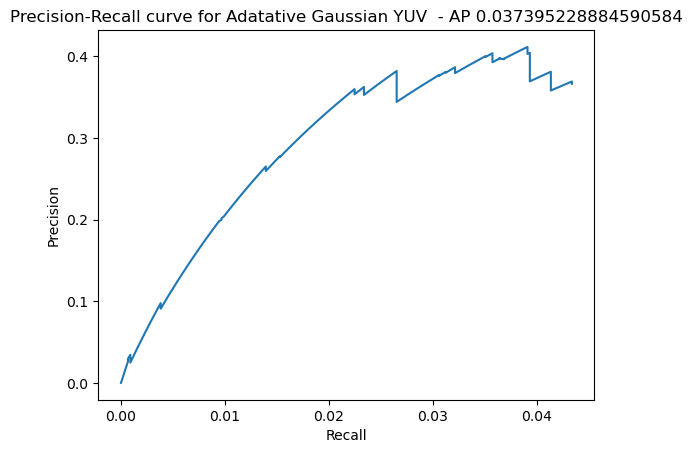

In [7]:
# @5min
means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames
singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',4,2,0.07, "YUV")
recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian YUV  - AP {np.mean(aps)}')

100%|██████████| 2141/2141 [05:15<00:00,  6.78it/s]


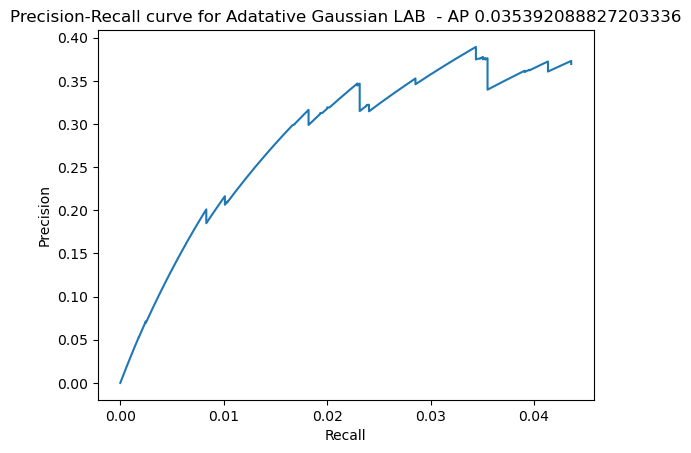

In [8]:
# @5min
means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames
singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',4,2,0.07, "LAB")
recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian LAB  - AP {np.mean(aps)}')

## Performing a Grid Search
We want to find optimal:
- Color Space
- Alpha
- Sigma
- P

In [9]:
color_space = ["RGB", "HSV", "LAB"]
alpha_space = [0.5, 1.5, 3]
sigma_space = [1, 2, 3]
p_space = [0.005, 0.01, 0.1]
len(color_space)*len(alpha_space)*len(sigma_space)*len(p_space)

81

In [10]:
def evaluate_params(color, alpha, sigma, p):
    means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames
    singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg',color=color, alpha=alpha, sigma=sigma, p=p)
    recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
    return (np.mean(aps), {"recs": recs, "prec": precs, "color": color, "alpha": alpha, "sigma": sigma, "p": p})

In [11]:
from tqdm import tqdm

In [12]:
pbar = tqdm(total = len(color_space)*len(alpha_space)*len(sigma_space)*len(p_space))
results = []
for color in color_spaces:
    for alpha in alpha_space:
        for sigma in sigma_space:
            for p in p_space:
                results.append(evaluate_params(color, alpha, sigma, p))
                pbar.update(1)

print(max(results))

100%|██████████| 2141/2141 [05:15<00:00,  6.79it/s]
108it [7:55:15, 319.07s/it]C:\Users\Yusep\AppData\Local\Temp\ipykernel_22360\1590168851.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(max(results))


TypeError: '>' not supported between instances of 'dict' and 'dict'

In [1]:
import pickle

results = pickle.load(open("results_task4.pkl", "rb"))

In [12]:
results_RGB = [r for r in results if r[1]["color"] == "RGB"]
results_RGB.sort(key=lambda y: y[0], reverse=True)
results_RGB = results_RGB[:3]

results_HSV = [r for r in results if r[1]["color"] == "HSV"]
results_HSV.sort(key=lambda y: y[0], reverse=True)
results_HSV = results_HSV[:3]

results_LAB = [r for r in results if r[1]["color"] == "LAB"]
results_LAB.sort(key=lambda y: y[0], reverse=True)
results_LAB = results_LAB[:3]


In [16]:
def plot_results(result_color):
    for r in result_color:
        alpha = r[1]["alpha"]
        sigma = r[1]["sigma"]
        p = r[1]["p"]
        color = r[1]["color"]
        precs = r[1]["prec"]
        recs = r[1]["recs"]
        aps = r[0]
        plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian {color} with alpha: {alpha}, sigma: {sigma} and p: {p}  - AP {aps}')

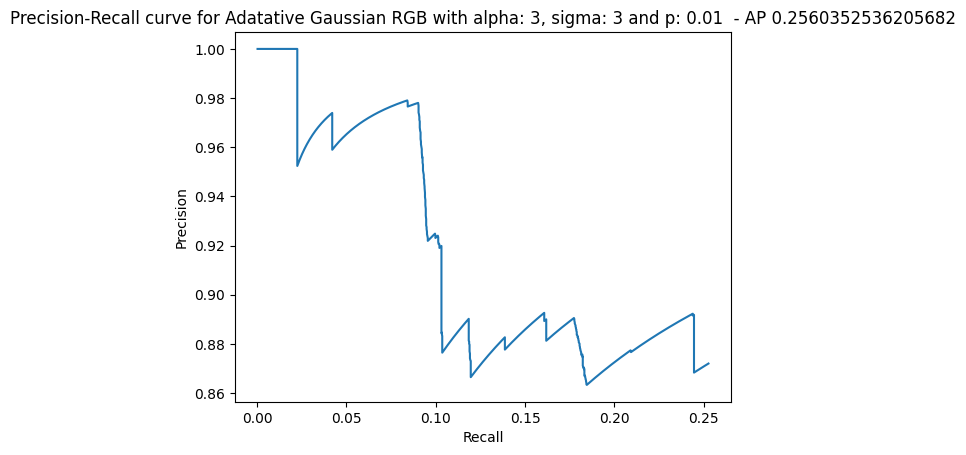

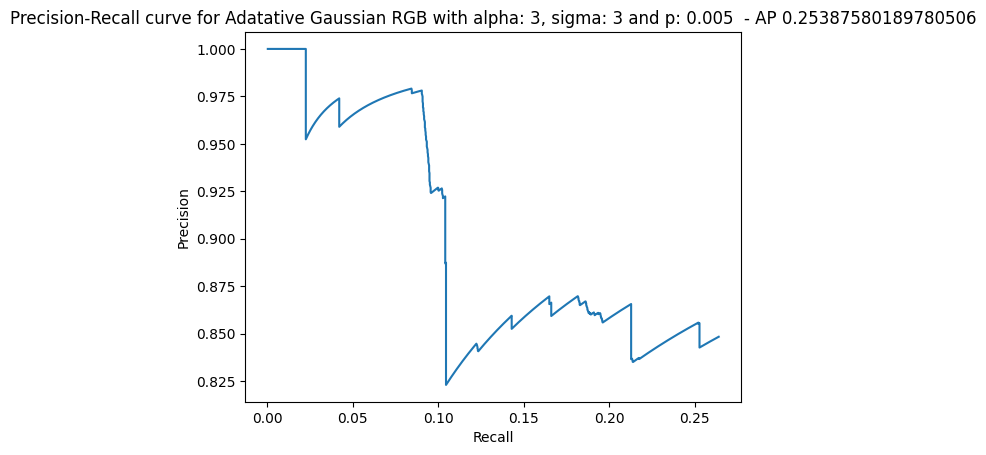

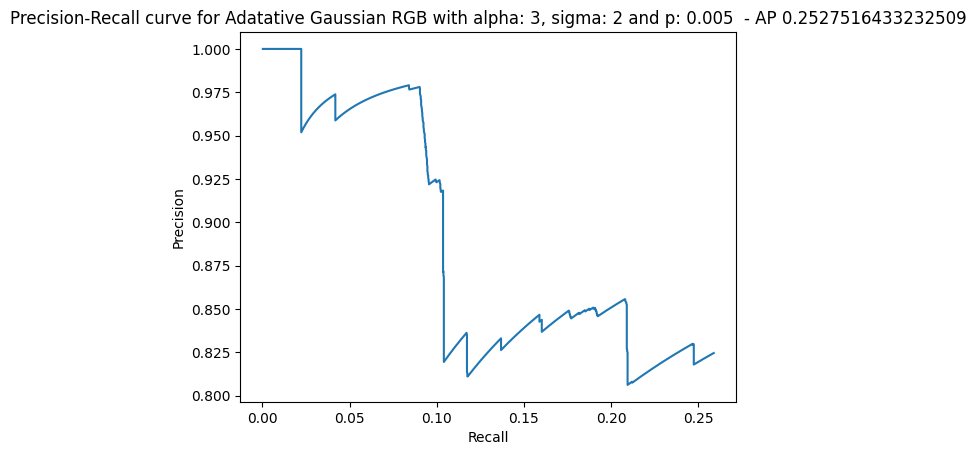

In [17]:
plot_results(results_RGB)

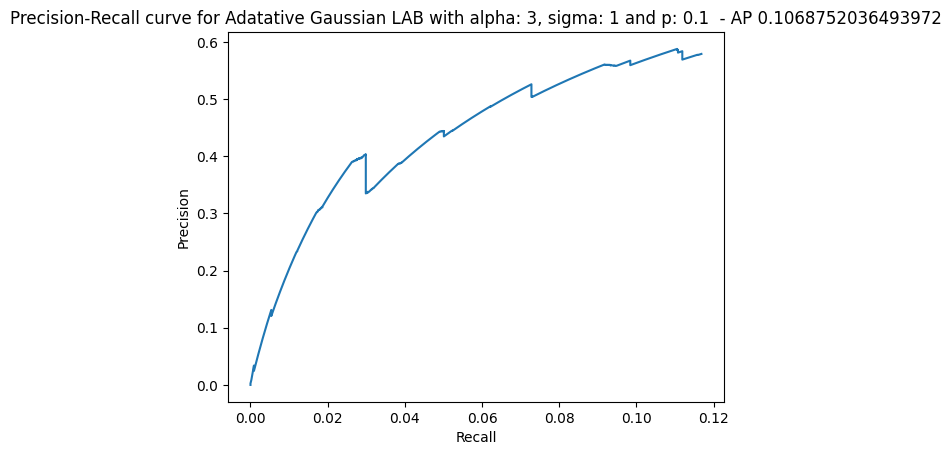

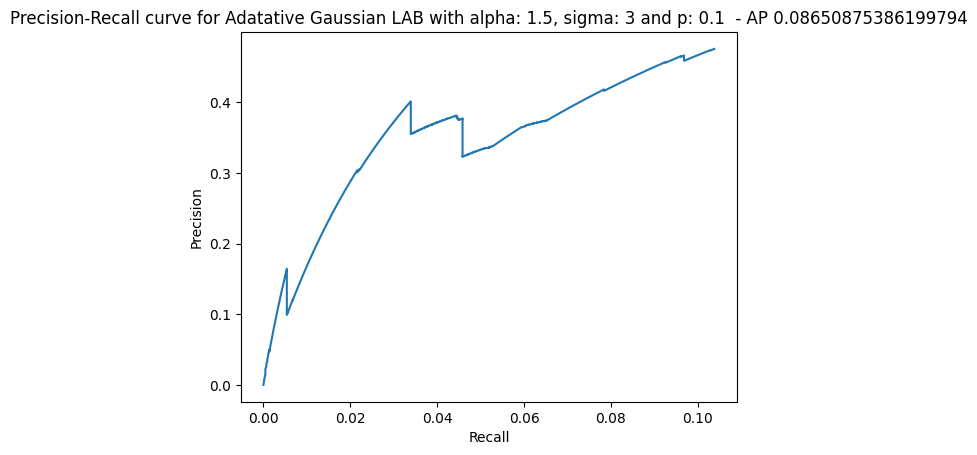

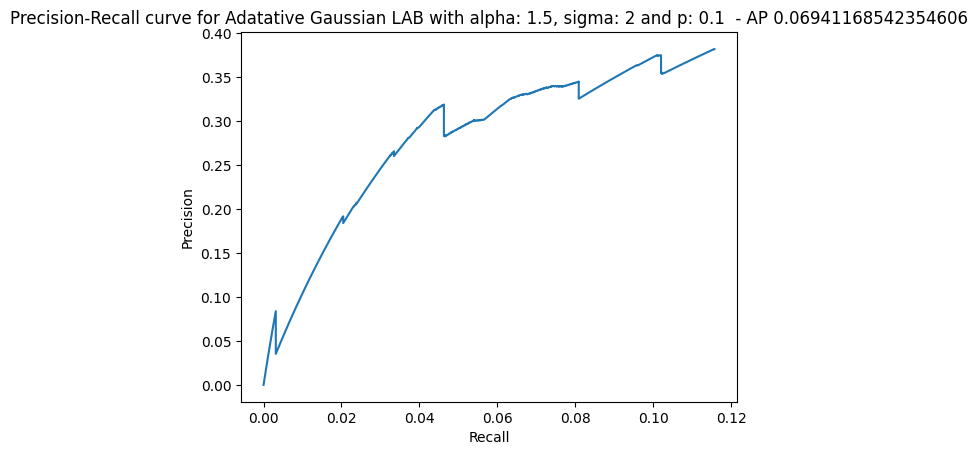

In [18]:
plot_results(results_LAB)

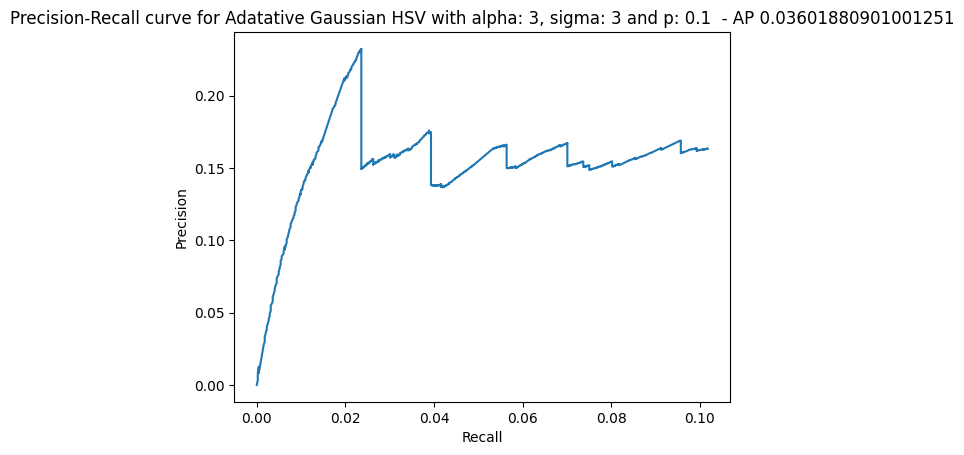

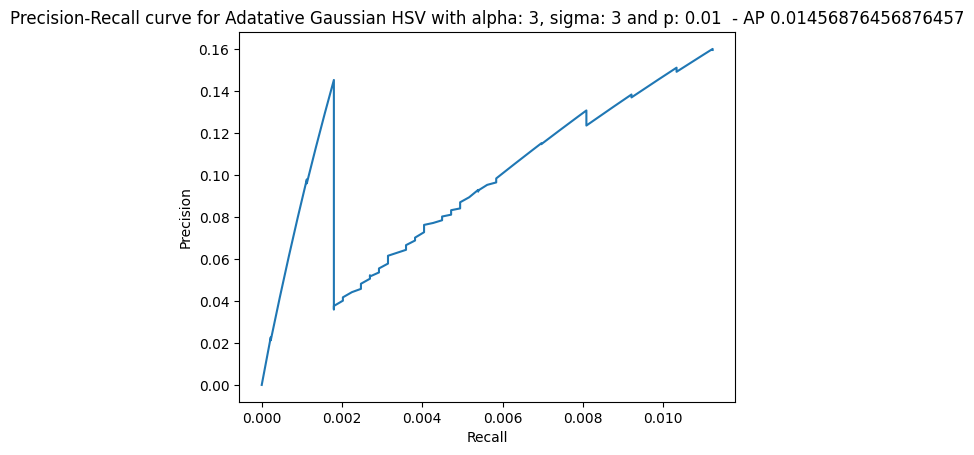

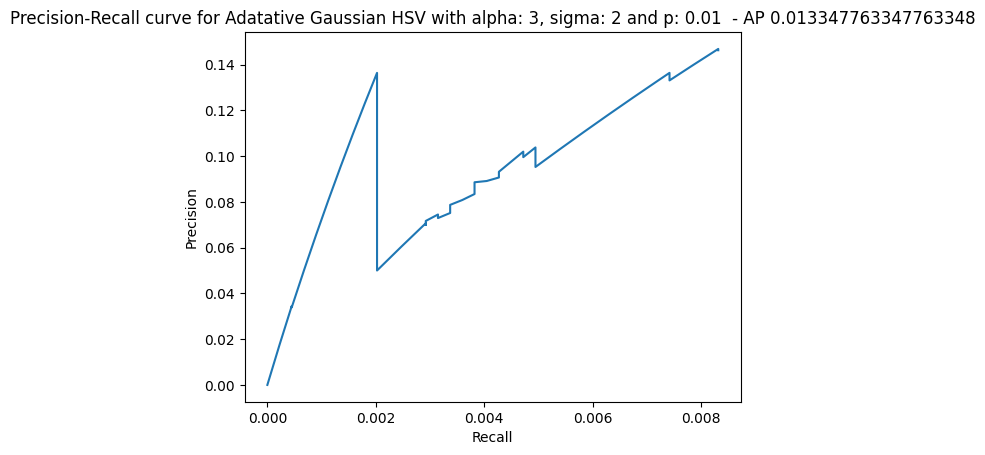

In [19]:
plot_results(results_HSV)

100%|██████████| 2141/2141 [05:00<00:00,  7.12it/s]


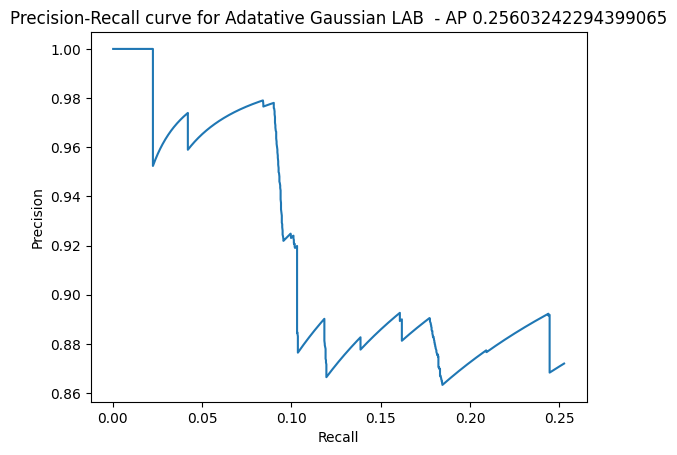

In [26]:
# @5min
means, stds = get_background_stats_color(data_path + 'vdo.avi', 1, 411) # 411 is the 20% of the frames
singleGaussianDetections = remove_background_adaptative_color(means,stds, data_path + 'vdo.avi',data_path + 'roi.jpg', color="RGB", alpha=3, sigma=3, p=0.01)
recs, precs, aps = ap_wo_conf(gt_notParked,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian LAB  - AP {np.mean(aps)}')